# ISS Projekt 2022/23                                                                     
# syntetické piano



## autor: Roman Poliačik
## xlogin:     xpolia05

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import soundfile as sf
from scipy import signal
from IPython.display import Audio

# 4.1 Základy

Na načítanie signálov som použil kód zo zadania. 
Jednu periódu tónu som získal výpočtom *T = 1/f*, kde f je relatívna frekvencia MIDI zo súboru midi.txt, pri zobrazovaní je rozdiel zanedbateľný.
Na výpočet DFT sa použila *numpy* funkcia ***numpy.fft.fft***, pri vykresľovaní spektra bolo potrebné vypočítať aj rozlíšenie DFT *F = Fs/N*, v tomto prípade          48kHz/24kvzorkov = 2Hz, čiže medzi dvoma koeficientmi DFT bude rozdiel 2Hz. 

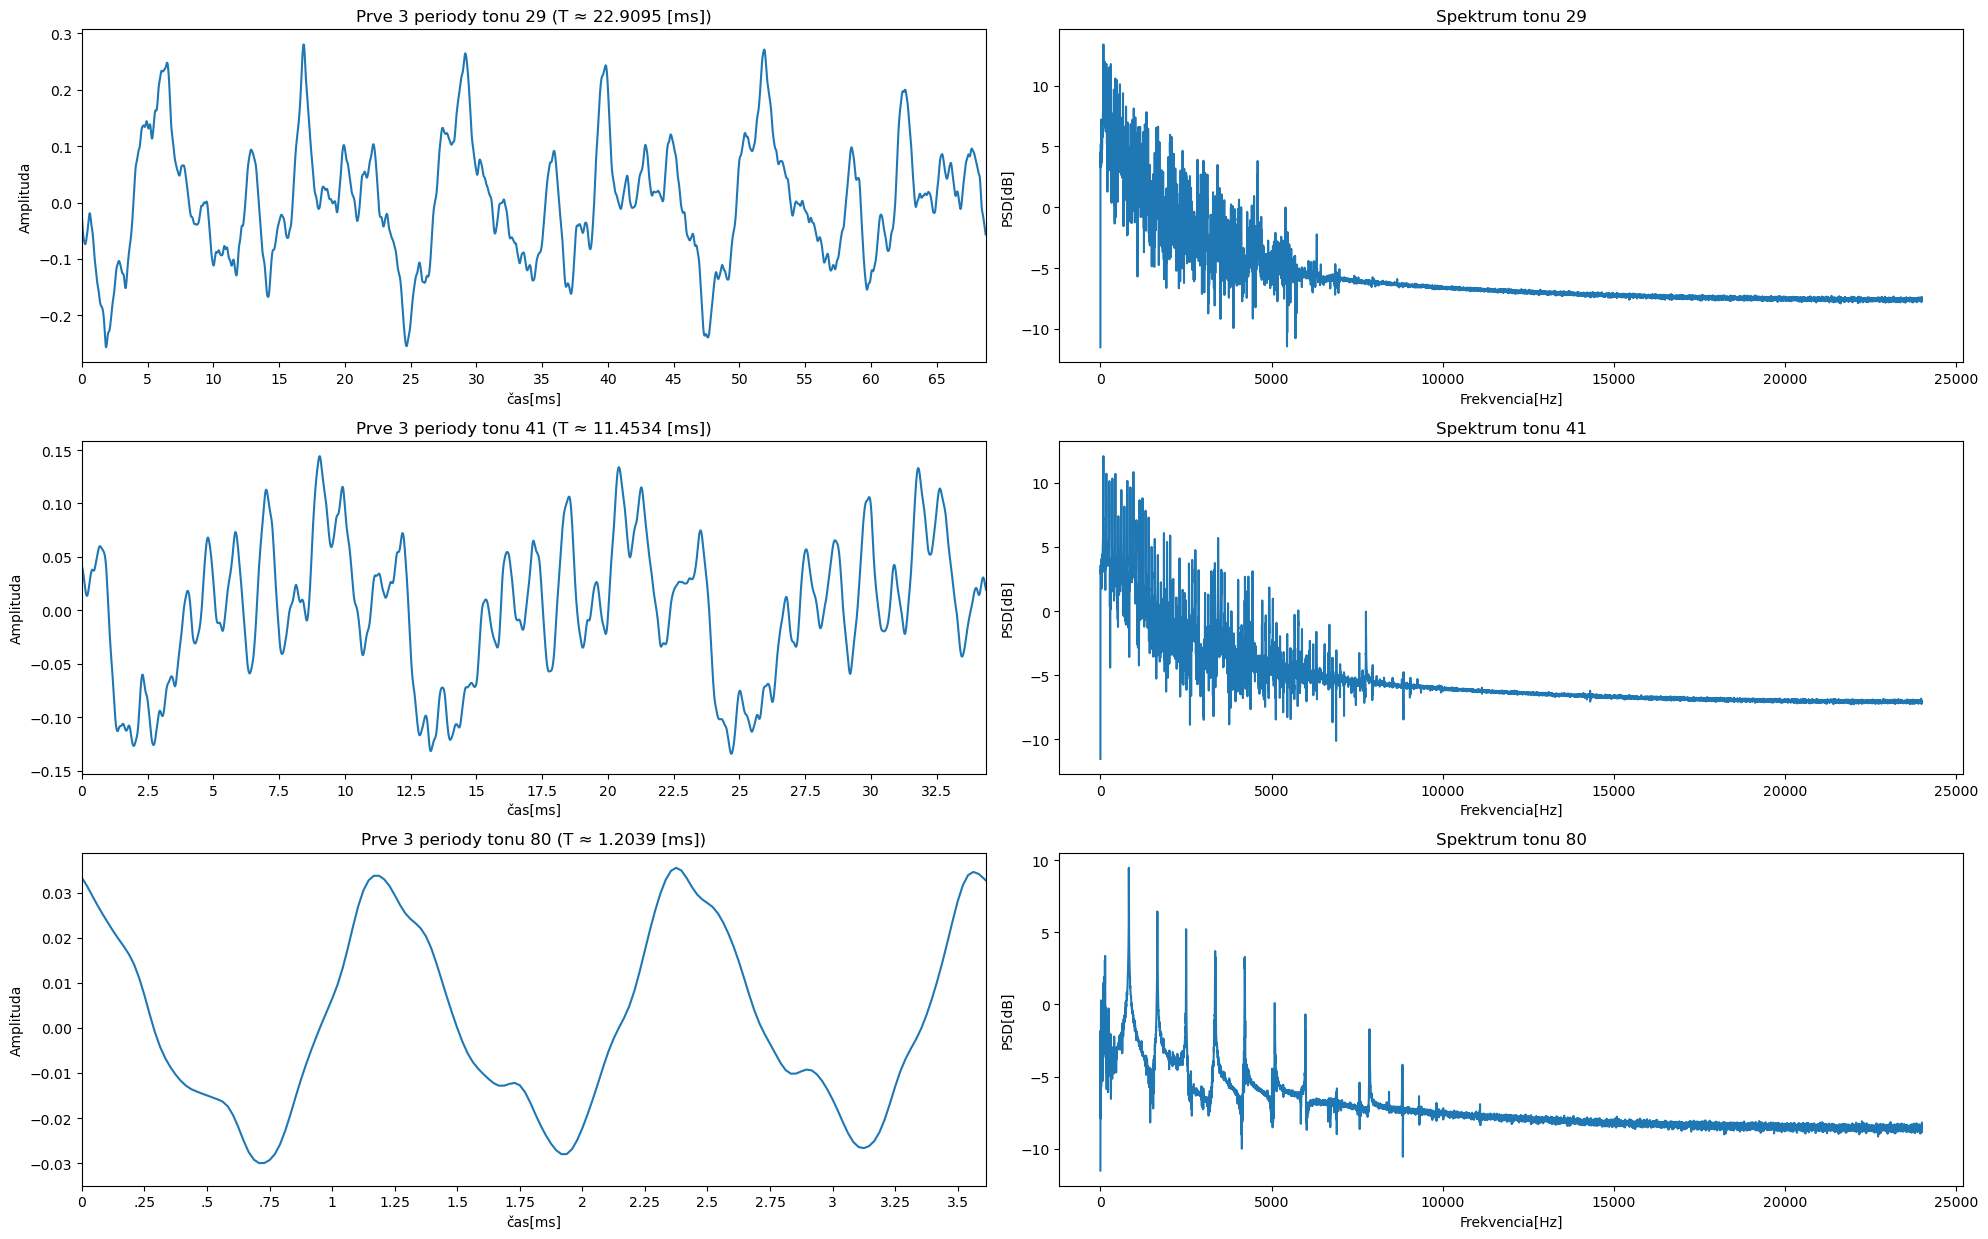

In [10]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read("klavir.wav")
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
                               # but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone
    

def plot_SIGNAL(r, c, midifreq, tone):
    T = 1 / midifreq
    segment = np.arange(xall[tone].size) / Fs
    #29; 43.65Hz
    #T = 1/43.65
    #3*(T*Fs) ;pocet vzorkov na 3 periody
    ax[r][c].set_title('Prve 3 periody tonu %d (T ≈ %1.4f [ms])' % (tone, T*1000))
    ax[r][c].set_xlabel('čas[ms]')
    if r==0:
        ax[r][c].set_xticks((0.00, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065), 
                            ("0", "5", "10", "15", "20", "25", "30", "35", "40", "45", "50", "55", "60", "65"))
    if r==1:
        ax[r][c].set_xticks((0.000, 0.0025,0.005, 0.0075, 0.010, 0.0125, 0.015, 0.0175, 0.020, 0.0225, 0.025, 0.0275, 0.030, 0.0325), 
                            ("0", "2.5", "5", "7.5", "10", "12.5", "15", "17.5", "20", "22.5", "25", "27.5", "30", "32.5"))
    if r==2:
        ax[r][c].set_xticks((0.0000, 0.00025, 0.0005, 0.00075, 0.0010, 0.00125, 0.0015, 0.00175, 0.0020, 0.00225, 0.0025, 0.00275, 0.0030, 0.00325, 0.0035), 
                            ("0", ".25", ".5", ".75", "1", "1.25", "1.5", "1.75", "2", "2.25", "2.5", "2.75", "3", "3.25", "3.5"))
        
    ax[r][c].set_ylabel('Amplituda')
    ax[r][c].set_xlim(0, T*3)
    ax[r][c].plot(segment, xall[tone])
    
def plot_PSD(r, c, tone):
    DFT = np.fft.fft(xall[tone])
    PSD = np.log(np.abs(DFT)**2 + 1e-5)
    PSDHalf = PSD[:PSD.size // 2]
    Fk = np.arange(PSDHalf.size) * (Fs / xall[tone].size)
    ax[r][c].set_title('Spektrum tonu %d' % tone)
    ax[r][c].set_xlabel('Frekvencia[Hz]')
    ax[r][c].set_ylabel('PSD[dB]')
    ax[r][c].plot(Fk, PSDHalf)

_, ax = plt.subplots(3, 2, figsize=(20, 12.5))

#vykreslovanie a ukladanie tonov
############################ TÓN 29 ############################
plot_SIGNAL(0, 0, 43.65, 29)
plot_PSD(0, 1, 29)
sf.write('audio/a_orig.wav', xall[29], Fs)

############################ TÓN 41 ############################
plot_SIGNAL(1, 0, 87.31, 41)
plot_PSD(1, 1, 41)
sf.write('audio/b_orig.wav', xall[41], Fs)

############################ TÓN 80 ############################
plot_SIGNAL(2, 0, 830.61, 80)
plot_PSD(2, 1, 80)
sf.write('audio/c_orig.wav', xall[80], Fs)

plt.tight_layout()

# 4.2 Určení základní frekvence

Základnú frekvenciu som získal použítím autokolerácie pre tóny do 42, pre tóny vyššie pomocou DFT. Autokoleráciu som použil pre nižšie tóny na základe toho, že pri týchto tónoch DFT zlyháva; dôvodom bude chýbajúca základná frekvencia, ktorú si (ne)možno všimnúť pri zobrazení spektra nejakého nižšieho tónu. Rozdiely medzi odhadom a MIDI si možno všimnúť vo výpise výsledkov nižšie. Tento rozdiel môže byť spôsobený rozladenosťou klavíru, nie až tak dobrou presnosťou autokolerácie alebo DFT, alebo tým, že MIDI určuje relatívnu frekvenciu, ktorá je teoretická.

Pre tóny 24 a 41 som použil autokoleráciu vyjadrenú funkciou *getFreq_ACF* s pomocou *signal.correlate*, kde som hladaľ najvyšší vrchol, ktorý sa nachádza za prahom polovice autokolerácie - prah som určil podľa toho, kde sa nachádzala prvá hodnota pod 0. Nakoniec základná frekvencia sa vypočíta vzorcom *f = Fs/N*, kde Fs je vzorkovacia frekvencia a N predstavuje vzdialenosť/počet koeficientov od polovice autokolerácie po hľadaný vrchol.

Pri tóne 108 som použil numpy funkciu *np.fft.fft* a frekvenciu som získal hodnotou koeficientu na ktorom sa nachádzala najvyššia hodnota magnitúdy.



In [3]:
def getFreq_DFT(tone):
    DFT = np.fft.fft(xall[tone])
    N = xall[tone].size
    koeff = np.arange(0,int(N/2) + 1)
    DFTmag = np.abs(DFT[koeff])
    f = koeff / N * Fs 
    return f[np.argmax(DFTmag)]

def getFreq_ACF(tone):
    corr = signal.correlate(xall[tone],xall[tone], "full")
    corr = corr[int(len(corr)/2):] #staci len druha polovica autokoleracie
    start = np.argmax(corr<0) #najdem vzdialenost prvej hodnoty y<0 - inak by funkcia np.argmax vzdy bola rovna 0 - tzv. PRAH
    peak_distance = np.argmax(corr[start:]) #argmax vrati na ktorom koeficiente sa nachadza najvyssia hodnota y                                                                                                                                                     
    freq = Fs/(peak_distance+start) #f0 = Fs/N
    return freq

mididata = np.loadtxt('midi.txt')
midiindex = 84
############################  VYPOCET POMOCOU AUTOKOLERACIE ############################ 
print("vypocet zakladni frekvence f0 pomoci ACF (do tonu 42)\n")
print("  ton       f0        MIDI")
for tone in range(MIDIFROM, 43):
    print("  %d      %1.3f      %1.2f\n             " % (tone, getFreq_ACF(tone), mididata[midiindex][1]))
    midiindex -= 1
    
############################      VYPOCET POMOCOU DFT      ############################
print("\nvypocet zakladni frekvence f0 pomoci DFT (od tonu 43)\n")
print("  ton       f0        MIDI")
for tone in range(43, MIDITO+1):
    print("  %d      %1.2f      %1.2f\n             " % (tone, getFreq_DFT(tone), mididata[midiindex][1]))
    midiindex -= 1


vypocet zakladni frekvence f0 pomoci ACF (do tonu 42)

  ton       f0        MIDI
  24      32.809      32.70
             
  25      34.757      34.65
             
  26      36.838      36.71
             
  27      39.024      38.89
             
  28      41.344      41.20
             
  29      43.796      43.65
             
  30      46.422      46.25
             
  31      49.180      49.00
             
  32      52.117      51.91
             
  33      55.172      55.00
             
  34      58.465      58.27
             
  35      61.935      61.74
             
  36      65.574      65.41
             
  37      69.465      69.30
             
  38      73.620      73.42
             
  39      77.922      77.78
             
  40      82.616      82.41
             
  41      87.751      87.31
             
  42      92.843      92.50
             

vypocet zakladni frekvence f0 pomoci DFT (od tonu 43)

  ton       f0        MIDI
  43      98.00      98.00
          

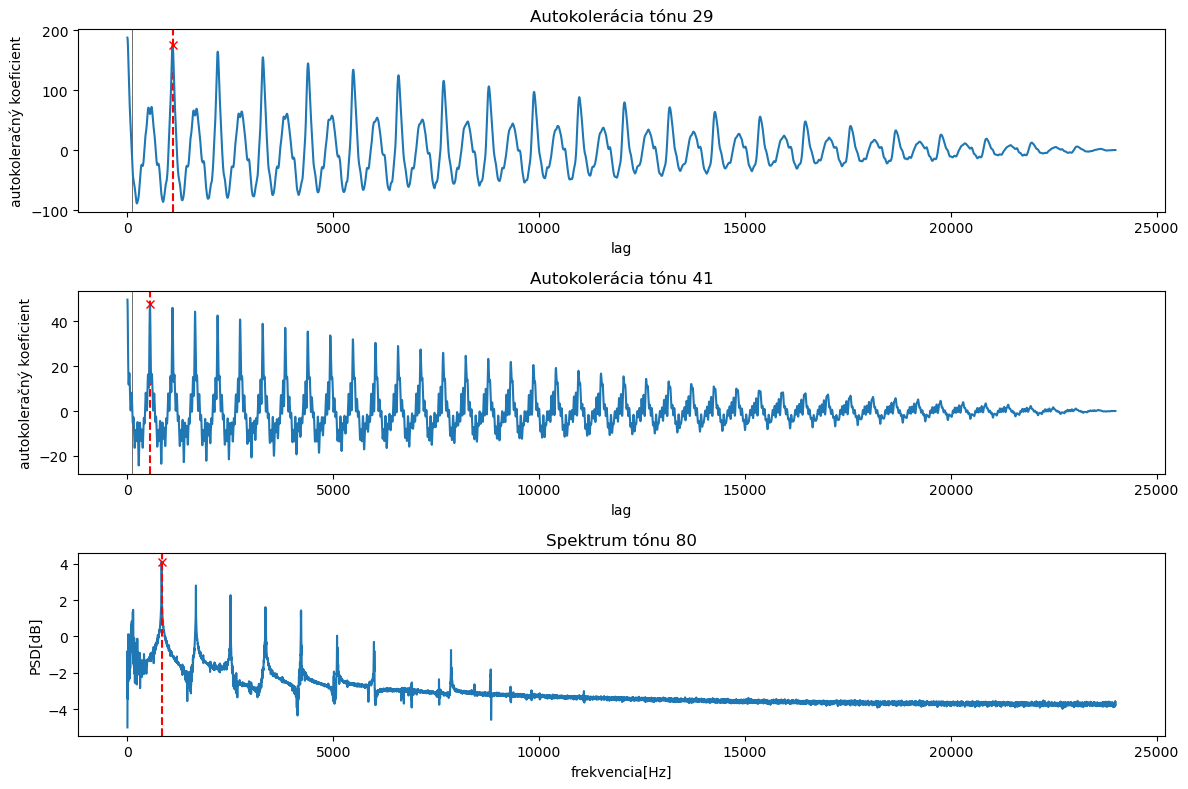

In [45]:
_, ax = plt.subplots(3, 1, figsize=(12, 8))
for idx, tone in enumerate([29, 41]):
    corr = signal.correlate(xall[tone],xall[tone], "full")
    corr = corr[int(len(corr)/2):]
    start = np.argmax(corr<0) 
    peak_max = np.max(corr[start:]) 
    peaks = signal.find_peaks(corr[start:], height=0) 
    peak_distance = peaks[0][np.where(peaks[1]["peak_heights"] == peak_max)[0][0]]
    N = peak_distance + start
    freq = Fs/N
    ax[idx].set_title("Autokolerácia tónu %d" % tone)
    ax[idx].set_xlabel('lag')
    ax[idx].set_ylabel('autokoleračný koeficient')
    ax[idx].axvline(x=N, c="r",linestyle="--")
    ax[idx].axvline(x=start, c="black", linewidth=0.4)
    ax[idx].plot(corr)
    ax[idx].plot(N,corr[N], marker="x", c="r")

DFT = np.fft.fft(xall[80])
DFT = np.log10(((np.abs(DFT)**2) + 1e-5))
DFTHalf = DFT[:DFT.size // 2]
Fk = np.arange(0, DFTHalf.size) * (Fs / (xall[tone].size))
peaks = signal.find_peaks(DFTHalf, height=0) #parameter height vytvori data s hodnotami magnitud
max_mag = np.max(DFTHalf) #zistim najvacsiu hodnotu magnitudy v DFT
fundamental_freq = peaks[0][np.where(peaks[1]["peak_heights"] == max_mag)[0][0]] * 2 #na rovnakom indexe, kde bol max_mag, bude hodnota vzdialenosti od 0
ax[2].set_title("Spektrum tónu 80")
ax[2].set_xlabel('frekvencia[Hz]')
ax[2].set_ylabel('PSD[dB]')
ax[2].plot(Fk, DFTHalf)
ax[2].plot(fundamental_freq, max_mag, marker="x", c="r")
ax[2].axvline(x=fundamental_freq, c="r", linestyle="--")

plt.tight_layout()

# 4.3 Zpřesnění odhadu základní frekvence f0

Na zpresnenie odhadu základnej frekvencie som použil frekvencie v rozpätí +/-2 koeficientov DFT, kedže rozlíšenie DFT je 2Hz, hľadám v rozsahu +/-4Hz okolo základnej  frekvencie - tento rozsah najmenší možný, vedel by som použiť aj väčší, s čím by bolo potrebné aj zvýšiť(kvôli presnosti) počet vzorkov v rozsahu - výpočet by sa stal časovo náročnejší a výsledok by to aj tak moc neovplyvnilo.       

Kvôli nepresnosti DFT u nízkych tónov som základnú frekvenciu získaval kombináciou **getFreq_DFT** a **getFreq_ACF**. Pre prvých 18 tónov(24-42) som použil základnú frekvenciu získanú pomocou autokolerácie, od tónu 43 pomocou DFT. 

Funkciu **getFreq_DTFT** som implementoval podobným spôsobom ako v python notebooku z prednášok *02_spectral_analysis_1*, s pridaním výpočtu modulu a fázy, ktoré sa spolu s nájdenou frekvenciou ukladajú na použitie v dalších úlohách do databázy *tonedata* 

In [5]:
def getFreq_DTFT(DFT_fmax, tone, f):
    FREQRANGE = 4
    FREQPOINTS = 400
    N = 24000
    n = np.arange(0,N)
    fsweep = np.linspace(DFT_fmax-FREQRANGE, DFT_fmax+FREQRANGE,FREQPOINTS)
    
    A = np.zeros([FREQPOINTS, N],dtype=complex) 
    for k in np.arange(0,FREQPOINTS):
        A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)
    DTFT = np.matmul(A,xall[tone].T)
    DTFT_fmax = fsweep[np.argmax(np.abs(DTFT))] 
    
    Xmodule = np.abs(DTFT[np.argmax(np.abs(DTFT))])  
    Xphase = np.angle(DTFT[np.argmax(np.abs(DTFT))]) 

    tonedata[tone][f][2] = DTFT_fmax
    tonedata[tone][f][0] = Xmodule
    tonedata[tone][f][1] = Xphase
    
    return DTFT_fmax

tonedata = np.zeros((MIDITO+1, 5, 3)) #ton  //  f1..5 //  modul/faza/frekvencia 
                                      #tonedata[ton][fi][0] = modul v fi atd...
print("ton       ACF        DTFT")
for tone in range(MIDIFROM, 43):   
    ACF_fmax = getFreq_ACF(tone)
    print("%d       %1.2f       %1.2f\n" % (tone,ACF_fmax, getFreq_DTFT(ACF_fmax, tone, 0)))
print("_____________________________")
print("ton       DFT         DTFT")
for tone in range(43, MIDITO+1):   
    DFT_fmax = getFreq_DFT(tone)
    print("%d       %1.2f       %1.2f\n" % (tone,DFT_fmax, getFreq_DTFT(DFT_fmax, tone, 0)))


ton       ACF        DTFT
24       32.81       32.16

25       34.76       32.54

26       36.84       36.19

27       39.02       38.33

28       41.34       39.23

29       43.80       44.37

30       46.42       43.54

31       49.18       46.80

32       52.12       54.45

33       55.17       55.58

34       58.47       59.38

35       61.94       61.99

36       65.57       65.34

37       69.46       69.07

38       73.62       72.97

39       77.92       77.31

40       82.62       81.96

41       87.75       87.70

42       92.84       92.93

_____________________________
ton       DFT         DTFT
43       98.00       98.45

44       104.00       104.31

45       110.00       110.51

46       118.00       117.07

47       124.00       123.19

48       130.00       130.51

49       138.00       138.27

50       146.00       146.67

51       156.00       155.39

52       164.00       164.61

53       350.00       349.55

54       370.00       370.31

55       392.00       392.3

# 4.4 Reprezentace klavíru

Každý tón je reprezentovaný pomocou piatich modulov a piatich fáz získaných z násobkov základnej frekvencie, pri každom násobku sa znovu vyhľadával presnejší odhad f pomocou DTFT. Kedže bolo potrebné vykresliť bod na krivke v spektre DFT použítím modula získaného z DTFT, modul bolo potrebné zlogaritmovať podobne                                    ako pri vykreslovaní DFT ( modul = log(modul^2) ).

In [6]:
#vypocet modulov a faz pro f1...f5 pre kazdy ton(f0 je uz vypocitane)
#cas vypoctu cca ~3 min

for tone in range(MIDIFROM, MIDITO+1):
    fprecise = tonedata[tone][0][2]
    f0 = [fprecise, 2*fprecise, 3*fprecise, 4*fprecise, 5*fprecise]
    
    for f in range(1,5):
        getFreq_DTFT(f0[f], tone, f)

print("done!")

done!


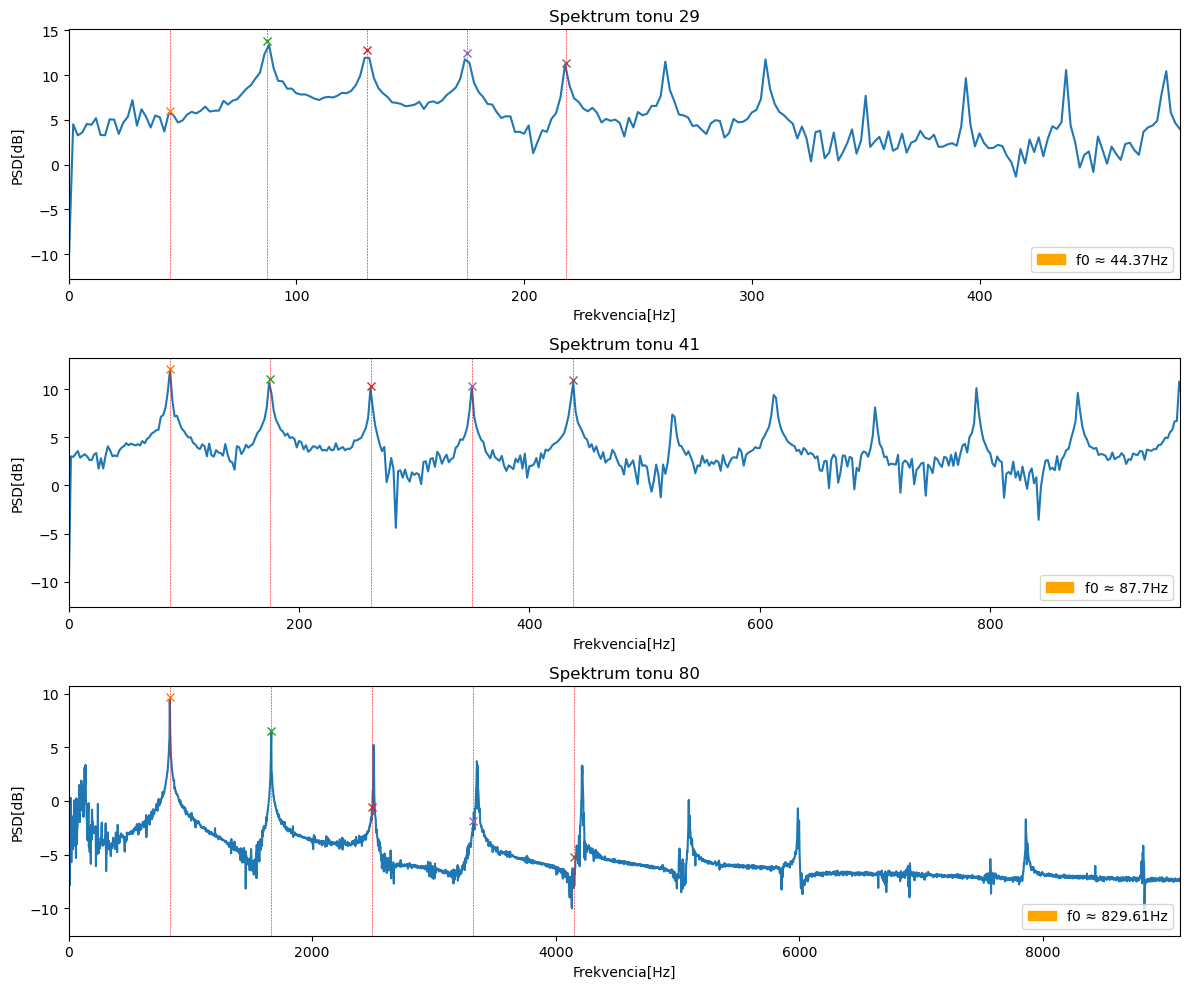

In [15]:
tones = [29, 41, 80]
def plot_fundamental(r, c, tone):
    freq0 = tonedata[tone][0][2]
    plot_PSD(r, c, tone)
    ax[r][c].set_xlim(0, 11*freq0)
    for f0 in range(5): 
        
        ax[r][c].axvline(x=tonedata[tone][f0][2], linewidth=0.4, c="r",linestyle="--")
        ax[r][c].plot(tonedata[tone][f0][2], np.log(tonedata[tone][f0][0]**2), marker='x')
        flabel = mpatches.Patch(color='orange',label='f0 ≈ {}Hz'.format(round(freq0, 2)))
        ax[r][c].legend(handles=[flabel], loc='lower right')
        
_, ax = plt.subplots(3, 1, figsize=(12, 10), squeeze=False)
for idx, tone in enumerate(tones):
    plot_fundamental(idx,0,tone)
    
plt.tight_layout()

# 4.5 Syntéza tónů

Tón je reprezentovaný 5 a 5 údajmi(modulov a fáz), rozhodol som sa ho syntetizovať pomocou <a href="https://en.wikipedia.org/wiki/Additive_synthesis" target="_blank">Harmonickej aditívnej syntézy</a>, ktorá úzko súvisí s konceptom Fourierovho radu a využíva moduly a fázy. Pre každý modul a fázu odpovedá jedna kosínusovka, takže môj syntetizovaný tón bude súčtom piatich takýchto kosínusových priebehov. Kedže sa používali moduly a fázy získané z DTFT, syntetizovaný tón bolo potrebné normalizovať a vynásobiť maximálnou amplitúdou pôvodnej. Syntetizované tóny sa pôvodným podobajú, ale nie príliš. Usúdil som, že to pochádza práve z faktu, že syntetizujem tón len piatimi kosínusovkami.

![vzorec harmonickej aditivnej syntezy](https://wikimedia.org/api/rest_v1/media/math/render/svg/5124d84cddf9529e675a93bc1a54bf478723b36e)

29
41
80


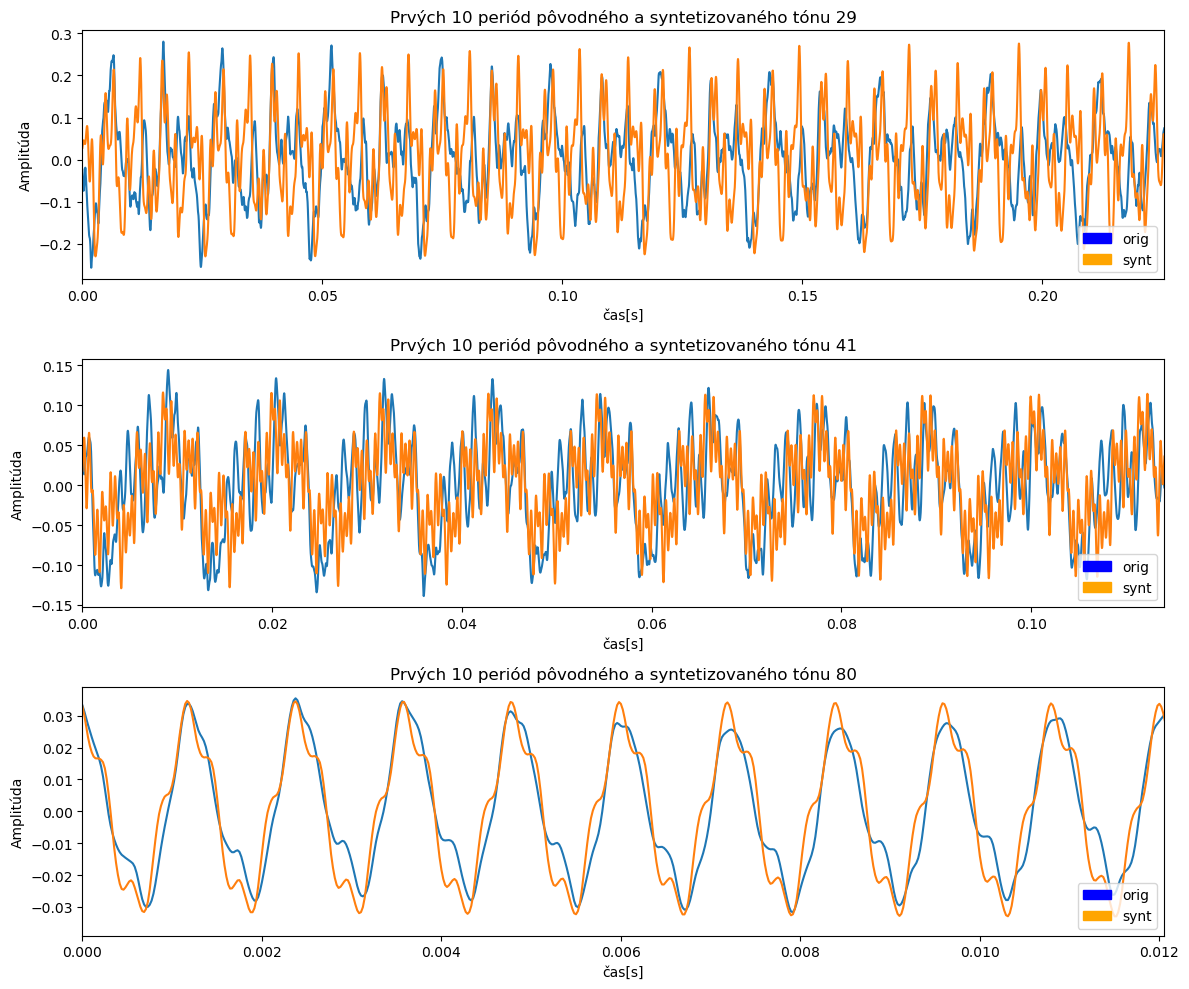

In [18]:
def synthesize_tone(tone, duration, volume=1.0, sampling_rate=48000):
    # vytvor casovu domenu v sekundach
    t = np.linspace(0, duration, int(duration * sampling_rate), False)
    # vypocitaj sumu piatich kosinusovych priebehov
    # rk - modul, k - koeficient, t - cas, fi - faza 
    synttone = np.real( tonedata[tone][0][0]*np.cos(2 * np.pi * 1 * tonedata[tone][0][2] * t + tonedata[tone][0][1]) + 
                        tonedata[tone][1][0]*np.cos(2 * np.pi * 2 * tonedata[tone][1][2] * t + tonedata[tone][1][1]) + 
                        tonedata[tone][2][0]*np.cos(2 * np.pi * 3 * tonedata[tone][2][2] * t + tonedata[tone][2][1]) + 
                        tonedata[tone][3][0]*np.cos(2 * np.pi * 4 * tonedata[tone][3][2] * t + tonedata[tone][3][1]) + 
                        tonedata[tone][4][0]*np.cos(2 * np.pi * 5 * tonedata[tone][4][2] * t + tonedata[tone][4][1]))
    
    synttone = ((synttone/max(synttone)) * max(xall[tone])) * volume #normalizacia, vynasobenie amplitudou povodnej, nastavenie hlasitosti
    return synttone

_, ax = plt.subplots(3, 1, figsize=(12, 10), squeeze=False)
blue = mpatches.Patch(color='blue', label='orig')
orange = mpatches.Patch(color='orange', label='synt')

for idx, tone in enumerate(tones):
    print(tone)
    synttone = synthesize_tone(tone=tone, duration=1, volume=1, sampling_rate=Fs)

    segment = np.arange(xall[tone].size) / Fs
    T = 1/tonedata[tone][0][2] # perioda

    if idx == 0:
        ax[0][0].plot(segment, xall[tone])
        ax[0][0].plot(segment, synttone[993:24993])
        ax[0][0].legend(handles=[blue, orange], loc='lower right')
        ax[0][0].set_title('Prvých 10 periód pôvodného a syntetizovaného tónu %d' % (tone))
        ax[0][0].set_xlabel('čas[s]')
        ax[0][0].set_ylabel('Amplitúda')
        ax[0][0].set_xlim(0, 10*T)
        
        sf.write('audio/a.wav', synttone, Fs)
    if idx == 1:
        ax[1][0].plot(segment, xall[tone])
        ax[1][0].plot(segment, synttone[1068:25068])
        ax[1][0].legend(handles=[blue, orange], loc='lower right')
        ax[1][0].set_title('Prvých 10 periód pôvodného a syntetizovaného tónu %d' % (tone))
        ax[1][0].set_xlabel('čas[s]')
        ax[1][0].set_ylabel('Amplitúda')
        ax[1][0].set_xlim(0, 10*T)
        
        sf.write('audio/b.wav', synttone, Fs)
    if idx == 2:
        ax[2][0].plot(segment, xall[tone])
        ax[2][0].plot(segment, synttone[1:24001])
        ax[2][0].legend(handles=[blue, orange], loc='lower right')
        ax[2][0].set_title('Prvých 10 periód pôvodného a syntetizovaného tónu %d' % (tone))
        ax[2][0].set_xlabel('čas[s]')
        ax[2][0].set_ylabel('Amplitúda')
        ax[2][0].set_xlim(0, 10*T)
        
        sf.write('audio/c.wav', synttone, Fs)

plt.tight_layout()

# 4.6 Generování hudby

Skladbu som vygeneroval vlastnou funkciou **generate_song**, vytvorím pole podľa dĺžky skladby, syntetizujem tón rovnako dlhý ako doba jeho trvania, kedže je skladba polyfónna, vo výslednom poli sčítavam tóny, ktoré hrajú v rovnaký moment.

In [47]:
def generate_song(filename='skladba.txt', Fs=48000):
    songdata = np.loadtxt(filename)
    #        songdata[row][column] 
    #     od      do     midi   hlasitost
    #     0       1       2        3
    linecount = songdata.shape[0]
    #najdi najvyssiu hodnotu do -> prepocitaj podla Fs -> toto bude velkost skladby
    songsize = songdata[0][1]
    for line in range(1, linecount):
        songsize_next = songdata[line][1]
        if songsize_next > songsize:
            songsize = songsize_next

    songsize = int((songsize / 1000) * Fs)
    song = np.zeros(songsize)

    for line in range(linecount):
        midi = int(songdata[line][2])
        if (Fs == 8000) and (midi == 108):
            continue
        dstart = int(songdata[line][0])
        indexstart = int(dstart/1000 * Fs) #kde v poli zacne ton
        dend = int(songdata[line][1])
        duration = (dend - dstart) / 1000 #dlzka tonu v sekundach
        volume = songdata[line][3] / 100 #hlasitost je v % (zistil som to az ked mi praskli usi po prvej skuske generovania)

        synttone = synthesize_tone(tone=midi, duration=duration, volume=volume, sampling_rate=Fs)
        for j in range(synttone.size):
            song[indexstart+j] += synttone[j] #kedze skladba je polyfonna, ak hra viac tonov v jeden moment - vysledok bude ich sucet

    return song

song8k = generate_song('skladba.txt', 8000)
song48k = generate_song('skladba.txt', 48000)

sf.write('audio/out_8k.wav', song8k[:10*8000], 8000)
sf.write('audio/out_48k.wav', song48k[:10*48000], 48000)
    

# 4.7 Spektrogram

vo vygenerovanej skladbe som si všimol chovanie podobné clipping-u. Až v spektograme som si všimol prečo. Každá tmavá vertikálna čiara predstavuje časť skladby, kde nehrá žiadny tón(sú tam nulové hodnoty). Tento jav bude najskôr spôsobený zlou implementáciou generovania skladby, ale zároveň môže za to aj zlá štruktúra súboru *skladba.txt*, podľa ktorej bola generovaná.

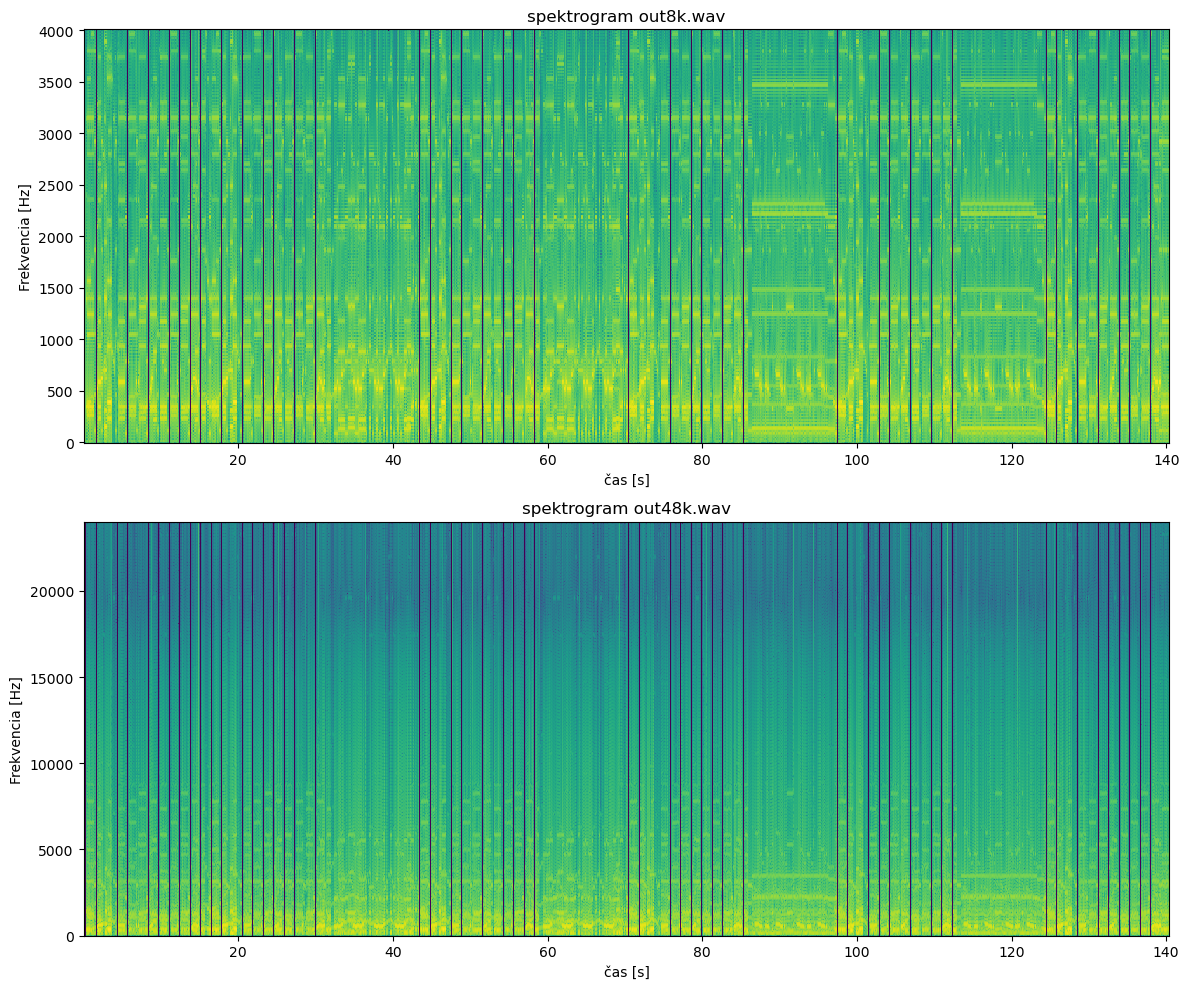

In [43]:
spectro8k = signal.spectrogram(x=song8k, fs=8000,  nfft=512, window=('tukey', 0.03))
spectro48k = signal.spectrogram(x=song48k, fs=48000,  nfft=2048, window=('tukey', 0.03))

spectro8k_log = 10 * np.log10(spectro8k[2] + 1e-20) 
spectro48k_log = 10 * np.log10(spectro48k[2] + 1e-20) 
_, ax = plt.subplots(2, 1, figsize=(12, 10), squeeze=False)

ax[0][0].pcolormesh(spectro8k[1], spectro8k[0], spectro8k_log )
ax[0][0].set_title('spektrogram out8k.wav')
ax[0][0].set_xlabel('čas [s]')
ax[0][0].set_ylabel('Frekvencia [Hz]')

ax[1][0].pcolormesh(spectro48k[1], spectro48k[0], spectro48k_log )
ax[1][0].set_title('spektrogram out48k.wav')
ax[1][0].set_xlabel('čas [s]')
ax[1][0].set_ylabel('Frekvencia [Hz]')
plt.tight_layout()